In [1]:
# Load "autoreload" extension so that code can change; set it so modules are reloaded before execution
%load_ext autoreload
%autoreload 2

In [110]:
from wien2k_parse.core import Wien2kParse as w2k
import pymatgen.io.vasp.outputs as vsp
import os.path as op
import numpy as np
from nmrlib.core import Efg, get_Q
import pandas as pd
import matplotlib.pyplot as plt
from uncertainties import ufloat

from scipy.constants import e, h, hbar

rawdata_path = op.abspath('../data/raw')

# WIEN2k

## Magnetic

In [3]:
wien = w2k(op.join(rawdata_path, 'sg67_wien_LaFeAsO/LaFeAsO'))
temp = 2
wien_efg = wien.efg['As1']
wienmag = np.append(wien_efg.V/1e21, [wien_efg.eta, temp])
wienmag

array([-0.78769   , -0.87427   ,  1.66196   ,  0.05209512,  2.        ])

## Non-magnetic

In [4]:
wien = w2k(op.join(rawdata_path, 'sg67_wien_nonmag_LaFeAsO/LaFeAsO'))
temp = 2
wien_efg = wien.efg['As1']
wiennonmag = np.append(wien_efg.V/1e21, [wien_efg.eta, temp])

# VASP

## Magnetic

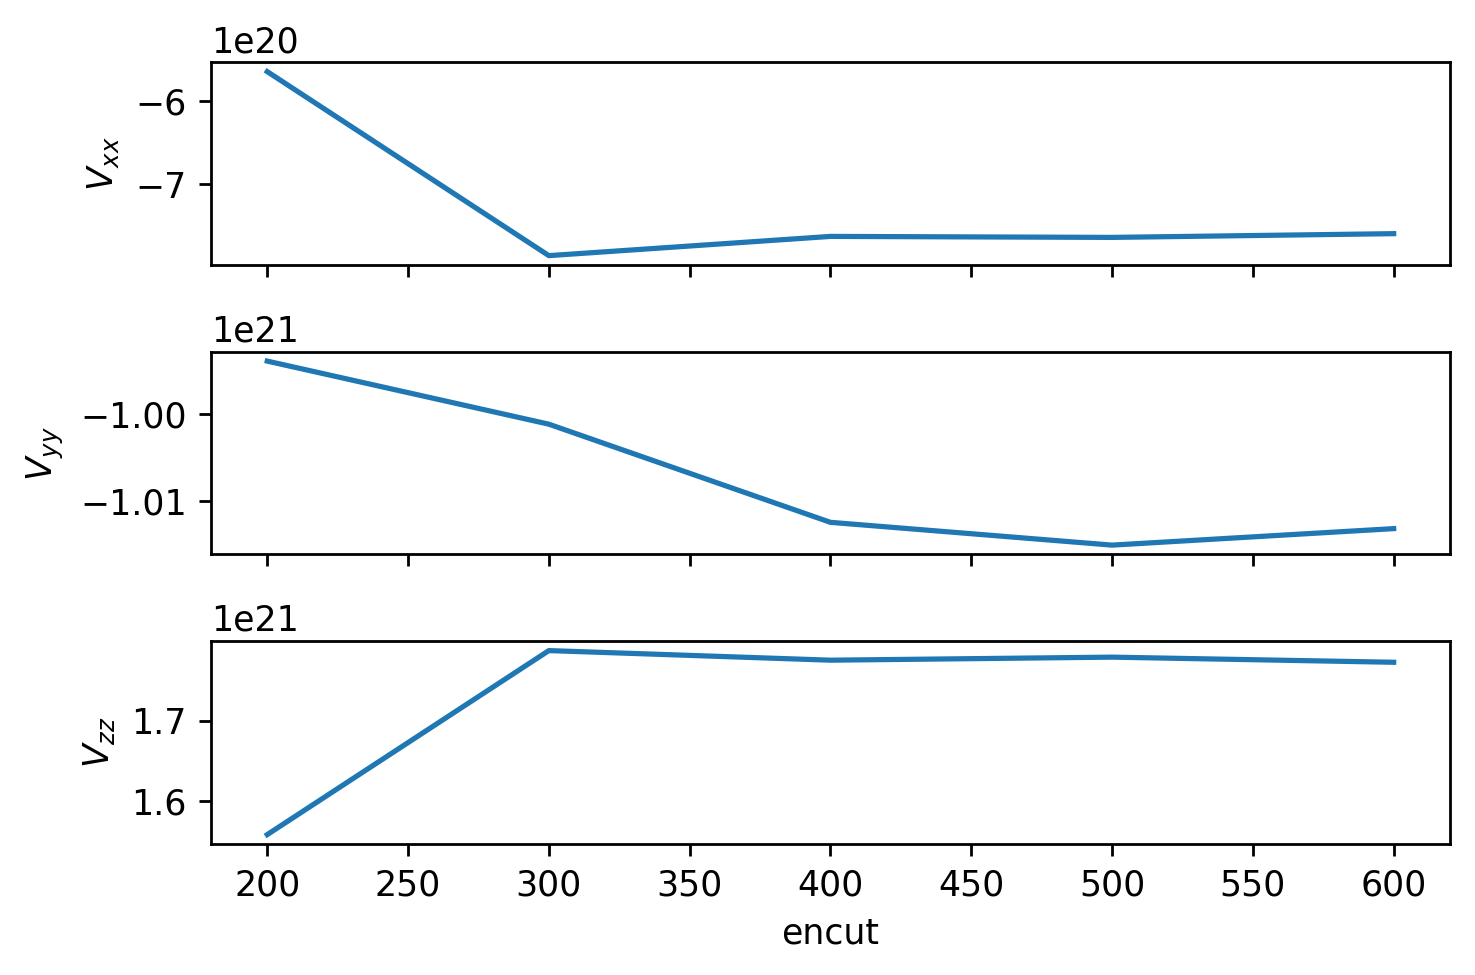

In [5]:
param = np.arange(200, 700, 100)
conv_path = 'sg67_vasp_LaFeAsO/conv/encut/'
Vxx = np.array([None]*param.size)
Vyy = np.array([None]*param.size)
Vzz = np.array([None]*param.size)
for i, val in enumerate(param):
    p = op.join(rawdata_path, conv_path, str(val))
    outcar = vsp.Outcar(op.join(p, 'OUTCAR'))
    #vasprun = vsp.Vasprun(op.join(p, 'vasprun.xml'))
    efg = Efg.from_gac_tensor(tensor=outcar.read_nmr_efg_tensor()[9]*1e20)
    Vxx[i] = efg.Vxx
    Vyy[i] = efg.Vyy
    Vzz[i] = efg.Vzz
fig, ax  = plt.subplots(3, dpi=250, sharex=True)
ax[0].plot(param, Vxx)
ax[1].plot(param, Vyy)
ax[2].plot(param, Vzz)
ax[0].set_ylabel(r'$V_{xx}$')
ax[1].set_ylabel(r'$V_{yy}$')
ax[2].set_ylabel(r'$V_{zz}$')
ax[2].set_xlabel('encut')
fig.tight_layout()

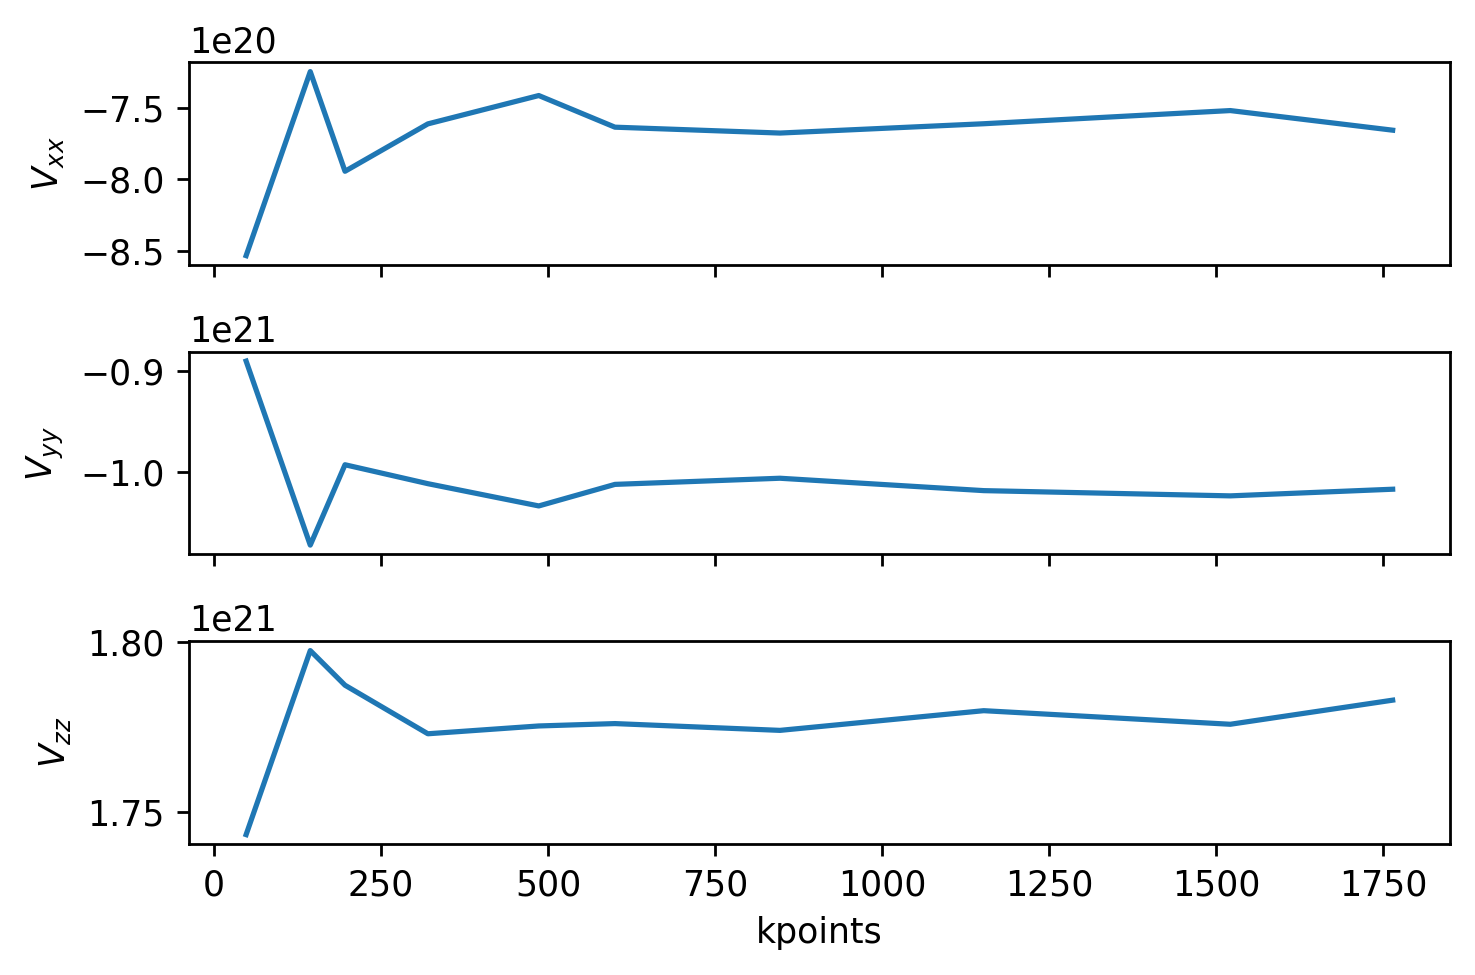

In [6]:
Vxx = np.array([None]*11)
Vyy = np.array([None]*11)
Vzz = np.array([None]*11)
kpts = np.array([None]*11)
for i, scale in enumerate(np.arange(4, 14)):
    p = op.join(rawdata_path, f'sg67_vasp_LaFeAsO/conv/kpoints/{scale}')
    outcar = vsp.Outcar(op.join(p, 'OUTCAR'))
    kpoints = vsp.Kpoints.from_file(op.join(p, 'KPOINTS'))
    #vasprun = vsp.Vasprun(op.join(p, 'vasprun.xml'))
    kpts[i] = np.prod(kpoints.kpts)
    efg = Efg.from_gac_tensor(tensor=outcar.read_nmr_efg_tensor()[9]*1e20)
    Vxx[i] = efg.Vxx
    Vyy[i] = efg.Vyy
    Vzz[i] = efg.Vzz
fig, ax  = plt.subplots(3, dpi=250, sharex=True)
ax[0].plot(kpts, Vxx)
ax[1].plot(kpts, Vyy)
ax[2].plot(kpts, Vzz)
ax[0].set_ylabel(r'$V_{xx}$')
ax[1].set_ylabel(r'$V_{yy}$')
ax[2].set_ylabel(r'$V_{zz}$')
ax[2].set_xlabel('kpoints')
fig.tight_layout()

In [7]:
outcar = vsp.Outcar(op.join(rawdata_path, 'sg67_vasp_LaFeAsO', 'OUTCAR'))
temp = 2
vasp_efg = Efg.from_gac_tensor(tensor=outcar.read_nmr_efg_tensor()[9]*1e20)
vaspmag = np.append(vasp_efg.V/1e21, [vasp_efg.eta, temp])

## Non-magnetic

In [8]:
outcar = vsp.Outcar(op.join(rawdata_path, 'sg67_vasp_nonmag_LaFeAsO', 'OUTCAR'))
temp = 2
vasp_efg = Efg.from_gac_tensor(tensor=outcar.read_nmr_efg_tensor()[9]*1e20)
vaspnonmag = np.append(vasp_efg.V/1e21, [vasp_efg.eta, temp])
vaspnonmag

array([ 1.36803833e+00,  1.36826189e+00, -2.73630022e+00,  8.17043646e-05,
        2.00000000e+00])

In [9]:
I = 3/2
gamma = 7.315021*1e6
Bi = 1.60
Q = get_Q('As', 75).n
wi = gamma*Bi
temp = 4.2
cosD = 0.9917172851021455
alpha = 0.3822292454941639
delta = np.arccos(cosD)/2
rho = 1/(1 - 2*np.sin(delta)**2)
wQ = alpha*wi/rho
Vzz = wQ*(4*I*(2*I - 1)*h)/(3*e*Q)
eta = np.sqrt((rho**2 - 1)*3)
Vxx = (eta - 1)*Vzz/2
Vyy = -Vzz - Vxx
exp_efg = Efg(V=[Vxx, Vyy, Vzz])
exp = np.append(exp_efg.V/1e21, [exp_efg.eta, temp])

# Grafe 2009

In [10]:
grafe = np.append(np.array([np.nan, np.nan, -3.14e21])/1e21, [0, 'room'])
grafe_opt = np.append(np.array([np.nan, np.nan, -2.67e21])/1e21, [0, 'room'])
grafe, grafe_opt

(array(['nan', 'nan', '-3.14', '0', 'room'], dtype='<U32'),
 array(['nan', 'nan', '-2.67', '0', 'room'], dtype='<U32'))

In [30]:
# d = {'wien': wienmag, 'vasp': vasp, 'exp': exp,
#      'wien %err': 100*np.abs(np.abs(wienmag - exp)/exp),
#      'vasp %err': 100*np.abs(np.abs(vasp - exp)/exp)}
units = np.array([r'$10^{21} \mathrm{V m}^{-2}$']*3 + [1, 'K'])
d = {'units': units, 'wien-mag': wienmag, 'vasp-mag': vaspmag, 'wien-nonmag': wiennonmag, 'vasp-nonmag': vaspnonmag,
     'grafe09': grafe, 'grafe09-opt': grafe_opt, 'exp': exp}
df = pd.DataFrame(d, index=[r'$V_{xx}$', r'$V_{yy}$', r'$V_{zz}$', r'$\eta$', r'$T$'])
#df.columns.name = r'$10^{21} \mathrm{V m}^{-2}$'
df_styler = df.style.set_table_attributes('style="font-size: 21px"')
df_styler

# Magnetic vs Non-Magnetic

In [130]:
# Carreta 4.2
mag = np.array([[-0.87427, -0.00000, 0.00000],
                [-0.00000, 1.66196, 0.00000],
                [0.00000, 0.00000, -0.78769]])
nonmag = np.array([[-2.80217, -0.00152, 0.00000],
                   [-0.00152, 1.40351, 0.00000],
                   [0.00000, 0.00000, 1.39866]])
Vzz = ufloat(2.33, 0.03)
eta = ufloat(0.32, 0.16)
Vxx = Vzz*(eta - 1)/2
Vyy = Vxx - eta*Vzz
exp = np.array([Vxx.n, Vyy.n, Vzz.n])
best_avg = 1
best = 0
for a in np.linspace(0, 1, 1000):
    _mix = (np.diag((a)*mag + (1 - a)*nonmag))
    ids = np.argsort(np.abs(_mix))
    mix = _mix[ids]
    avg = np.average(np.abs((np.abs(exp) - np.abs(mix))/np.abs(exp)))
    if avg < best_avg:
        best_avg = avg
        best = a
mix_T = best*mag + (1 - best)*nonmag
mix = Efg.from_gac_tensor(tensor=mix_T)
mix_T, mix.eta, best, Vxx, Vyy, Vzz, 0.7/2.4, 1 - (0.7/2.4), 1 - (0.8/2.4)**2#, Vxx, Vyy, Vzz, eta

(array([[-2.26760714e+00, -1.09853854e-03,  0.00000000e+00],
        [-1.09853854e-03,  1.47517231e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  7.92434825e-01]]),
 0.3010828911491896,
 0.2772772772772773,
 -0.7921999999999999+/-0.18667886864881092,
 -1.5377999999999998+/-0.18744865963777924,
 2.33+/-0.03,
 0.2916666666666667,
 0.7083333333333333,
 0.8888888888888888)

In [119]:
# Fu 145
mag = np.array([[-0.87427, -0.00000, 0.00000],
                [-0.00000, 1.66196, 0.00000],
                [0.00000, 0.00000, -0.78769]])
nonmag = np.array([[-2.80217, -0.00152, 0.00000],
                   [-0.00152, 1.40351, 0.00000],
                   [0.00000, 0.00000, 1.39866]])
Vzz = ufloat(2.39, 0.03)
eta = ufloat(0.14, 0.02)
Vxx = Vzz*(eta - 1)/2
Vyy = Vxx - eta*Vzz
exp = np.array([Vxx.n, Vyy.n, Vzz.n])
best_avg = 1
best = 0
for a in np.linspace(0, 1, 1000):
    _mix = (np.diag((a)*mag + (1 - a)*nonmag))
    ids = np.argsort(np.abs(_mix))
    mix = _mix[ids]
    avg = np.average(np.abs((np.abs(exp) - np.abs(mix))/np.abs(exp)))
    if avg < best_avg:
        best_avg = avg
        best = a
mix_T = best*mag + (1 - best)*nonmag
mix = Efg.from_gac_tensor(tensor=mix_T)
mix, mix.eta, best,
mix_T, mix.eta, best, 1 - best, 1 - (0.7/2.5), 1 - (0.7/2.5)**2, Vxx, Vyy, Vzz, eta

(array([[-2.47409893e+00, -1.26134134e-03,  0.00000000e+00],
        [-1.26134134e-03,  1.44749048e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.02660845e+00]]),
 0.17011541607874603,
 0.17017017017017017,
 0.8298298298298299,
 0.72,
 0.9216,
 -1.0277+/-0.02715916051721776,
 -1.3623+/-0.02938741227124294,
 2.39+/-0.03,
 0.14+/-0.02)

In [ ]:
gamma = 7.292*1e6
Q = get_Q('As', 75).n
Vrho_mukada = 8.8e6*h/e/Q*2
#Vrho_jaafar = 0.382*1.6*gamma*4*h/e/Q
Vrho_jaafar = 0.382*1.6*gamma*2
nu_mukada, Vrho_jaafar

In [ ]:
g = 4.596e7/(2*np.pi)
g

In [ ]:
e = 1.609e-19
h = 6.62607004e-34
I = 3/2
Q = 0.31e-28#get_Q('As', 75).n
gamma = 4.596e7/(2*np.pi)#7.292*1e6
wi = 1.6*gamma
w1 = np.array([11.77, 11.72, 11.84])*1e6
w2 = np.array([20.57, 20.52, 20.64])*1e6
gp = (w1 + w2)/(2*wi)
gm = (w2 - w1)/(2*wi) - 1
alpha = np.sqrt((gp**2 + gm**2)/2 - 1)
rho = 2*alpha/(gp**2 - alpha**2 - 1)
eta = np.sqrt(3*(rho**2 - 1))
wQ = alpha*wi/rho
Vzz = wQ*(4*I*(2*I - 1)*h)/(3*e*Q)
eta, Vzz, Q